# 1. Business understanding
The dataset is about conversion rate of a website. The goal is to understand what factors are the most important for conversion rate and come up with recommendations to improve the conversion rate.


# 2. Data understanding

## 2.1 Load libraries

In [18]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
%matplotlib inline

## 2.2 Load dataset

In [25]:
data = pd.read_csv('../data/conversion_rate/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


We can see that there are no missing values in the dataset. The dataset contains 5 columns, including 3 categorical columns and 2 numerical columns. The target variable is 'converted'.

In [6]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [12]:
# Check for duplicates
data.duplicated().sum()

299903

We cannot tell if the previous result is duplicated or not, as we don't know the user_id. So let's assume that the user_id is unique and there are no duplicates in the dataset.

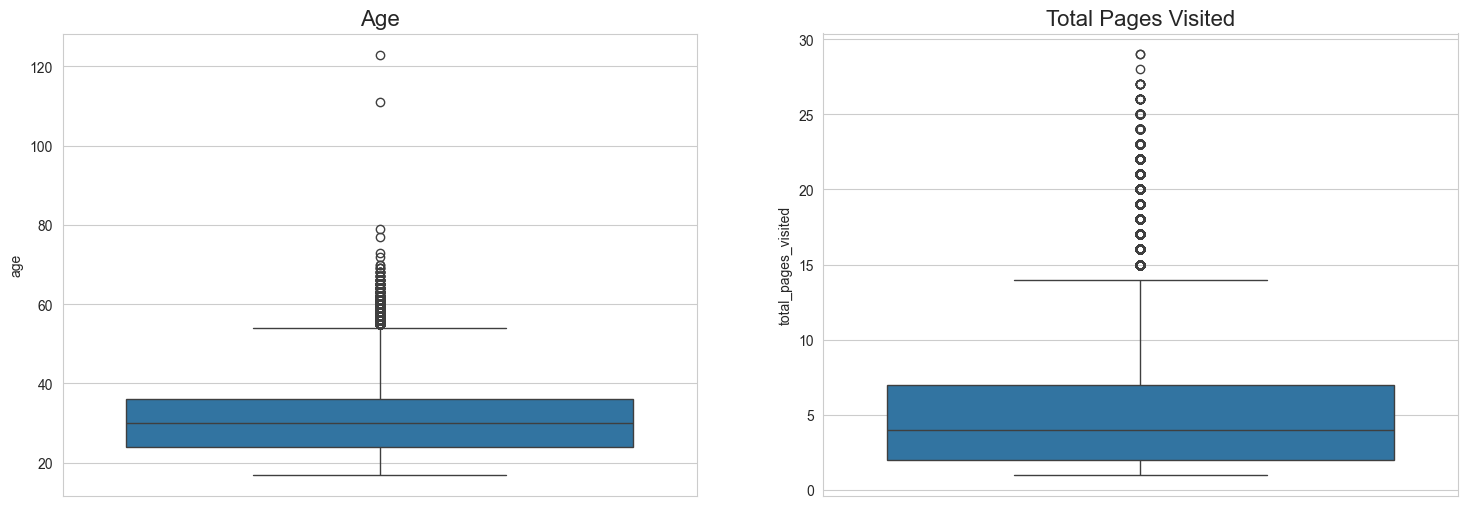

In [8]:
# Set a boxplot to check the distribution of numerical columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.boxplot(data['age'], ax=ax[0])
ax[0].set_title('Age', fontsize=16)
sns.boxplot(data['total_pages_visited'], ax=ax[1])
ax[1].set_title('Total Pages Visited', fontsize=16)
plt.show()

## 2.3 Remove Outliers
Typically, age should be below 100. So, first let check outliers and clean the dataset

In [9]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two records that are invalid, let's first remove them directly

In [10]:
data = data[data['age'] < 100]

## 2.4 Exploratory Data Analysis

### 2.4.1 Visualization of different countries

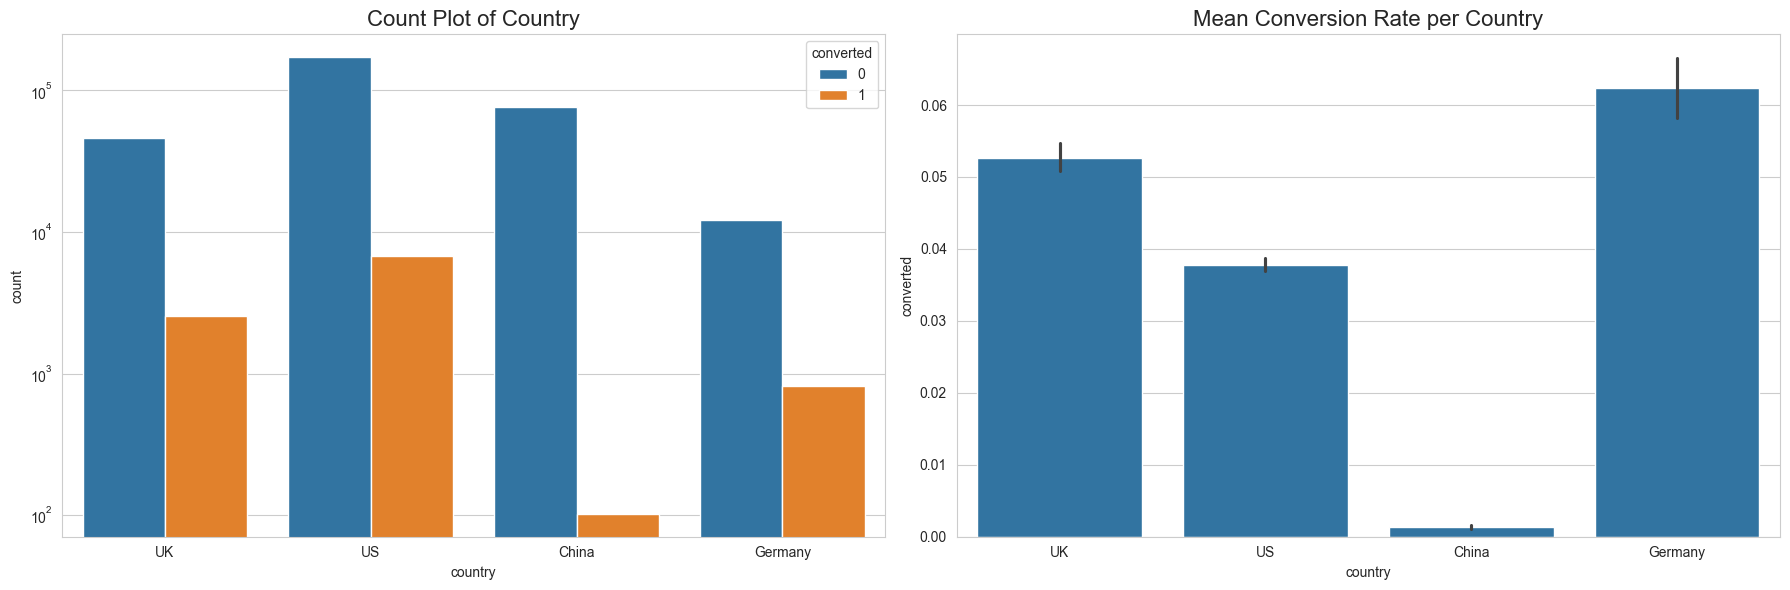

In [11]:
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.2 Visualization of different user types

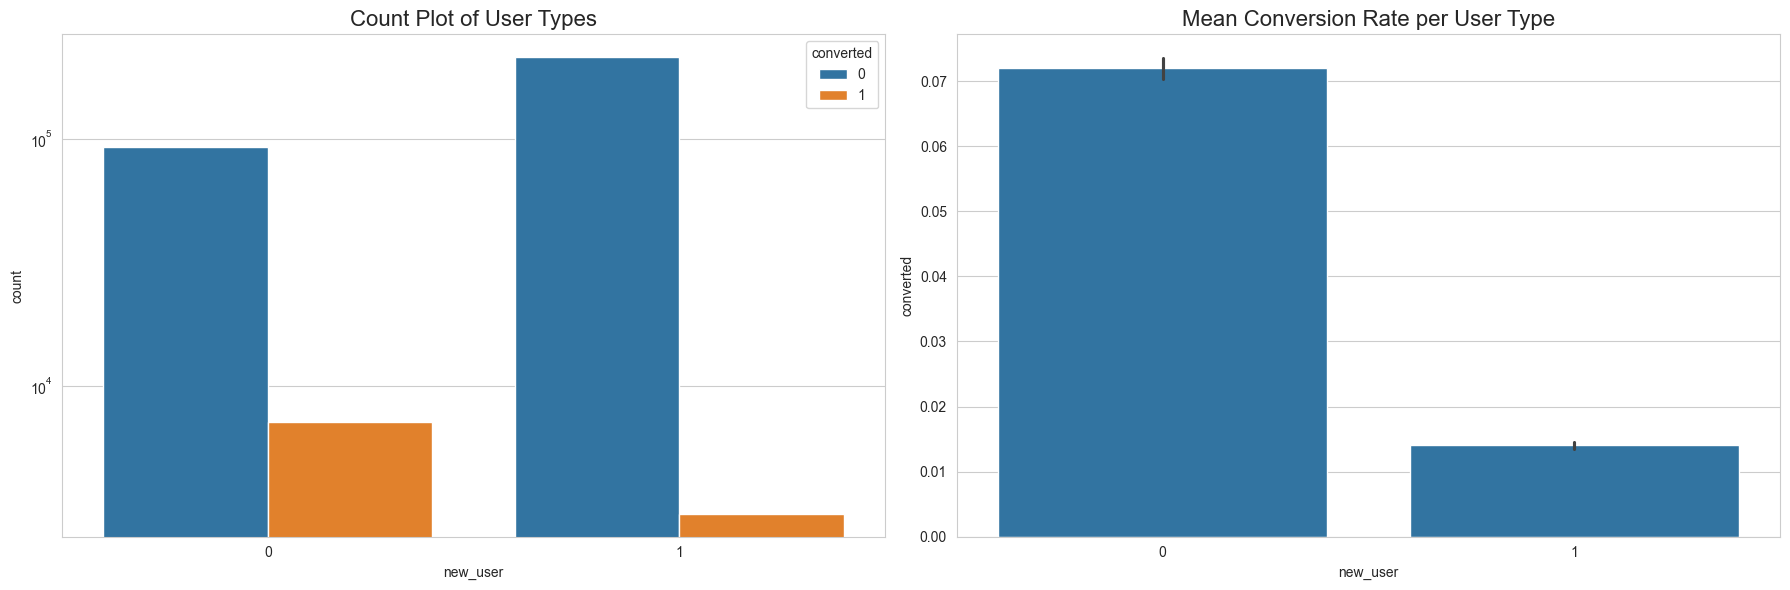

In [13]:

grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.3 Visualization of different sources

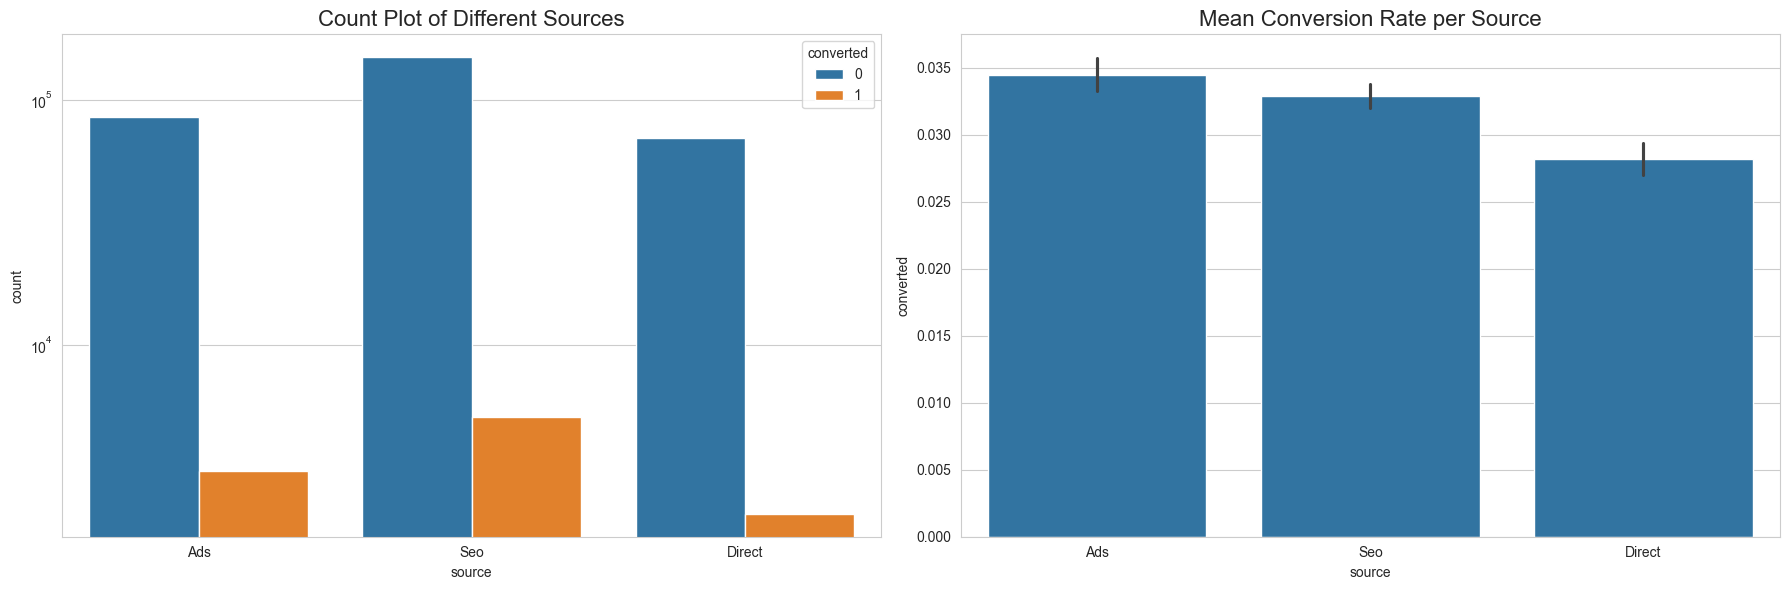

In [14]:

grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.4 Visualization of age

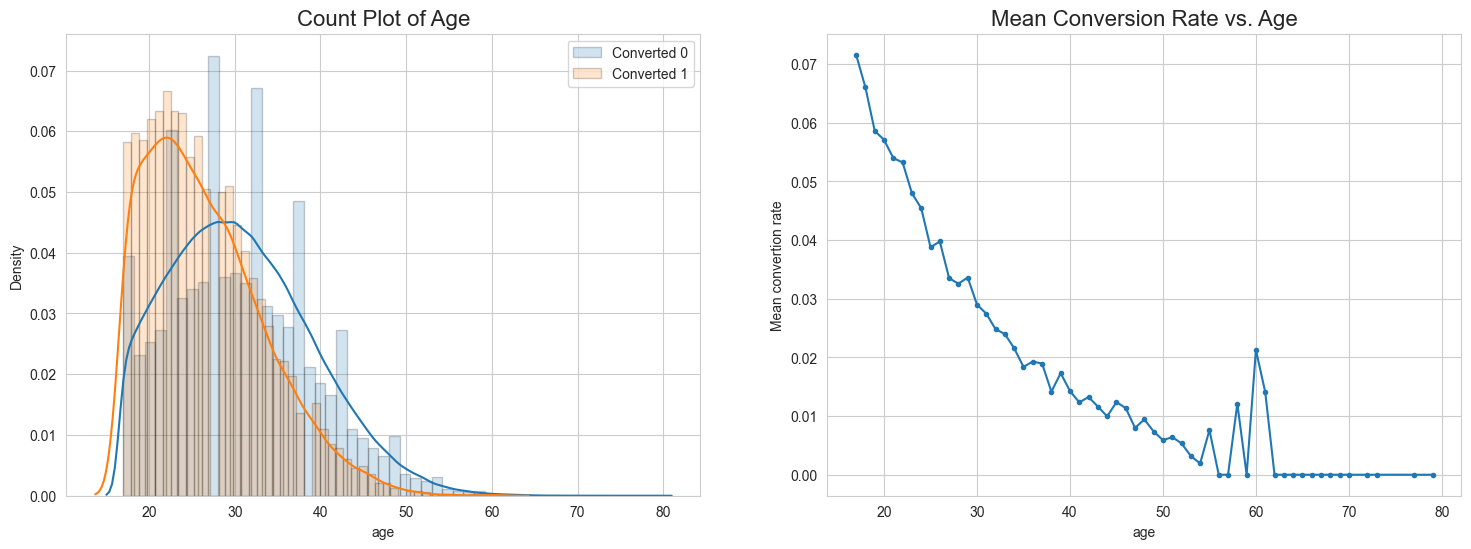

In [15]:
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

### 2.4.5 Visualization of total page visited

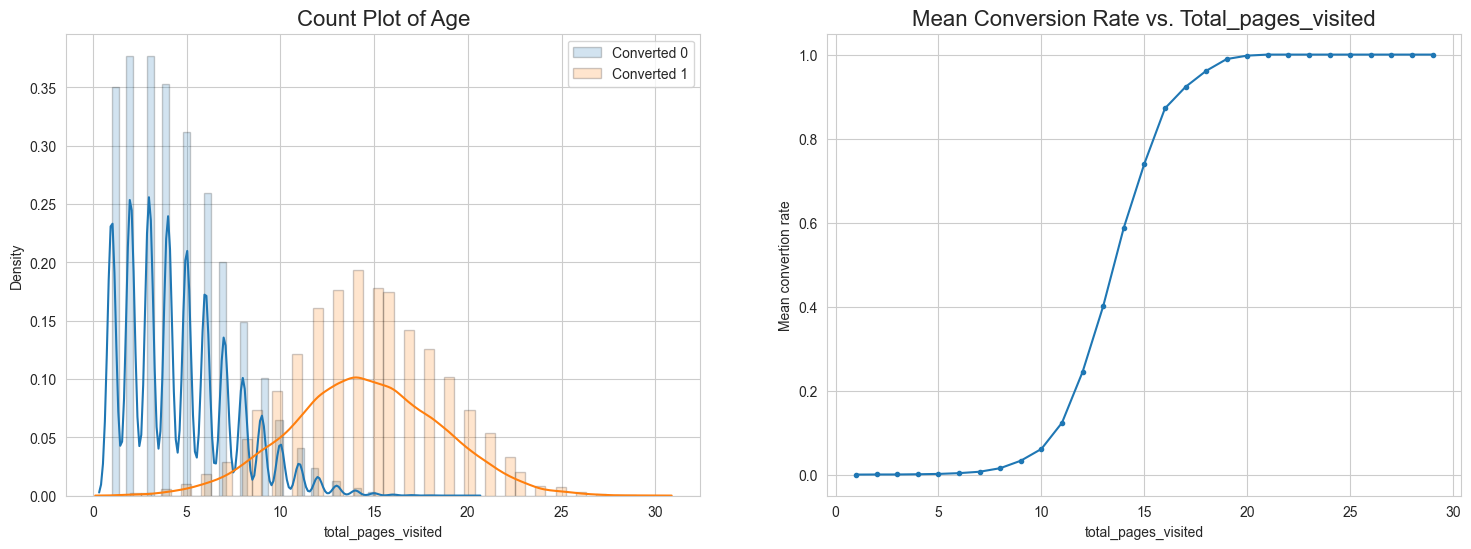

In [16]:
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

# 3. Data Preparation
Now we need to prepare the data for machine learning. We need to convert categorical variables into numerical variables, and split the data into training and test datasets.
We could use one-hot encoding to convert categorical variables into numerical variables. However, for tree-based models, we don't need to do this. We can simply convert the categorical variables into numerical variables using label encoding.


In [27]:
# set noralization for numerical columns
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
data[['age_n', 'total_pages_visited_n']] = normalizer.fit_transform(data[['age', 'total_pages_visited']])
# We can one hot encode the categorical variables
data = pd.get_dummies(data, columns=['country', 'source'], dtype=int)


In [28]:
# This is how the dataset looks like after one-hot encoding
data

,age,new_user,total_pages_visited,converted,age_n,total_pages_visited_n,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0.999201,0.039968,0,0,1,0,1,0,0
1,23,1,5,0,0.977176,0.212430,0,0,0,1,0,0,1
2,28,1,4,0,0.989949,0.141421,0,0,0,1,0,0,1
3,39,1,5,0,0.991882,0.127164,1,0,0,0,0,0,1
4,30,1,6,0,0.980581,0.196116,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0.944986,0.327111,0,0,0,1,1,0,0
316196,27,1,6,0,0.976187,0.216930,0,0,0,1,0,1,0
316197,25,0,4,0,0.987441,0.157991,1,0,0,0,1,0,0
316198,22,0,4,0,0.983870,0.178885,0,0,0,1,0,0,1


In [29]:
# To make it cleaner, let's drop the original columns
data_n = data.drop(['age', 'total_pages_visited'], axis=1)
data_n

,new_user,converted,age_n,total_pages_visited_n,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,1,0,0.999201,0.039968,0,0,1,0,1,0,0
1,1,0,0.977176,0.212430,0,0,0,1,0,0,1
2,1,0,0.989949,0.141421,0,0,0,1,0,0,1
3,1,0,0.991882,0.127164,1,0,0,0,0,0,1
4,1,0,0.980581,0.196116,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
316195,1,0,0.944986,0.327111,0,0,0,1,1,0,0
316196,1,0,0.976187,0.216930,0,0,0,1,0,1,0
316197,0,0,0.987441,0.157991,1,0,0,0,1,0,0
316198,0,0,0.983870,0.178885,0,0,0,1,0,0,1


In [ ]:
# Let's check the correlation between the variables
plt.figure(figsize=(12, 10))
sns.heatmap(data_n.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()


In [30]:
# Let's split the data into training and test datasets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_n, test_size=0.25, random_state=11)


# 4. Modeling
Now that we have prepared the data, we can start to build the model. We will benchmark the following models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- Neural Network
- Support Vector Machine
- K-Nearest Neighbors
- Naive Bayes
- Decision Tree

In [34]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [35]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

In [ ]:
# Train the models
for name, model in models.items():
    model.fit(train.drop('converted', axis=1), train['converted'])
    print(name + ' trained.')

Logistic Regression trained.
Random Forest trained.
Gradient Boosting trained.
XGBoost trained.
[LightGBM] [Info] Number of positive: 7639, number of negative: 229511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 237150, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032212 -> initscore=-3.402684
[LightGBM] [Info] Start training from score -3.402684
LightGBM trained.
Neural Network trained.


# 5. Evaluation

In [14]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: H2ODeprecationWarning: ``summary()`` is deprecated, please use ``show_summary()`` or ``get_summary()`` instead
  import sys


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


## 5.2 data for training
Split into 75% training and 25% test dataset

In [15]:

strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

## 5.3 Build random forest model

In [16]:

model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1683002964387_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         3.16855e+06            20           20           20            1734          3125          2514.22

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11945464552172459
RMSE: 0.3456221137625956
LogLoss: 0.37997993642589206
Mean Per-Class Error: 0.04082089594856752
AUC: 0.9928408503225029
AUCPR: 0.991674136912456
Gini: 0.9856817006450058

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02636630749288713
       0       1       Error    Rate
-----  ------  ------  -------  ------------------
0      216752  12748   0.0555   (12748.0/229500.0)
1      5989    223519  0.0261   (5989.0/229508.0)
Total  222741  236267  0.0408   (18737.0/459008.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0263663    0.959772  376
max f2                       0.00874678   0.977331  387
max f0point5                 0.0910119    0.961984  348
max accuracy                 0.0354478    0.959201  371
max precision                0.994537     0.999764  3
max recall                   0.00249432   1         393
max specificity              0.999472     0.999996  0
max absolute_mcc             0.0263663    0.918757  376
max min_per_class_accuracy   0.0424033    0.957612  368
max mean_per_class_accuracy  0.0354478    0.959201  371
max tns                      0.999472     229499    0
max fns                      0.999472     228489    0
max fps                      8.37221e-05  229500    399
max tps                      0.00249432   229508    393
max tnr                      0.999472     0.999996  0
max fnr                      0.999472     0.99556   0
max fpr                      8.37221e-05  1         399
max tpr                      0.00249432   1         393

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.81 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100064                   0.993438           1.99953   1.99953            0.999782         0.996616     0.999782                    0.996616            0.020008        0.020008                   99.953    99.953             0.0200037
2        0.0200018                   0.9893             1.99735   1.99844            0.998692         0.991352     0.999238                    0.993985            0.0199644       0.0399725                  99.735    99.844             0.039942
3        0.0300017                   0.984966           1.99953   1.9988             0.999782         0.987156     0.999419                    0.991709            0.0199949       0.0599674                  99.9529   99.8803            0.0599326
4        0.0400015                   0.979535           1.99953   1.99898            0.999782         0.98237      0.99951                     0.989375            0.0199949       0.0799624                  99.9529   99.8985            0.0799231
5        0.0500013                   0.973994           1.99822   1.99883            0.999129       

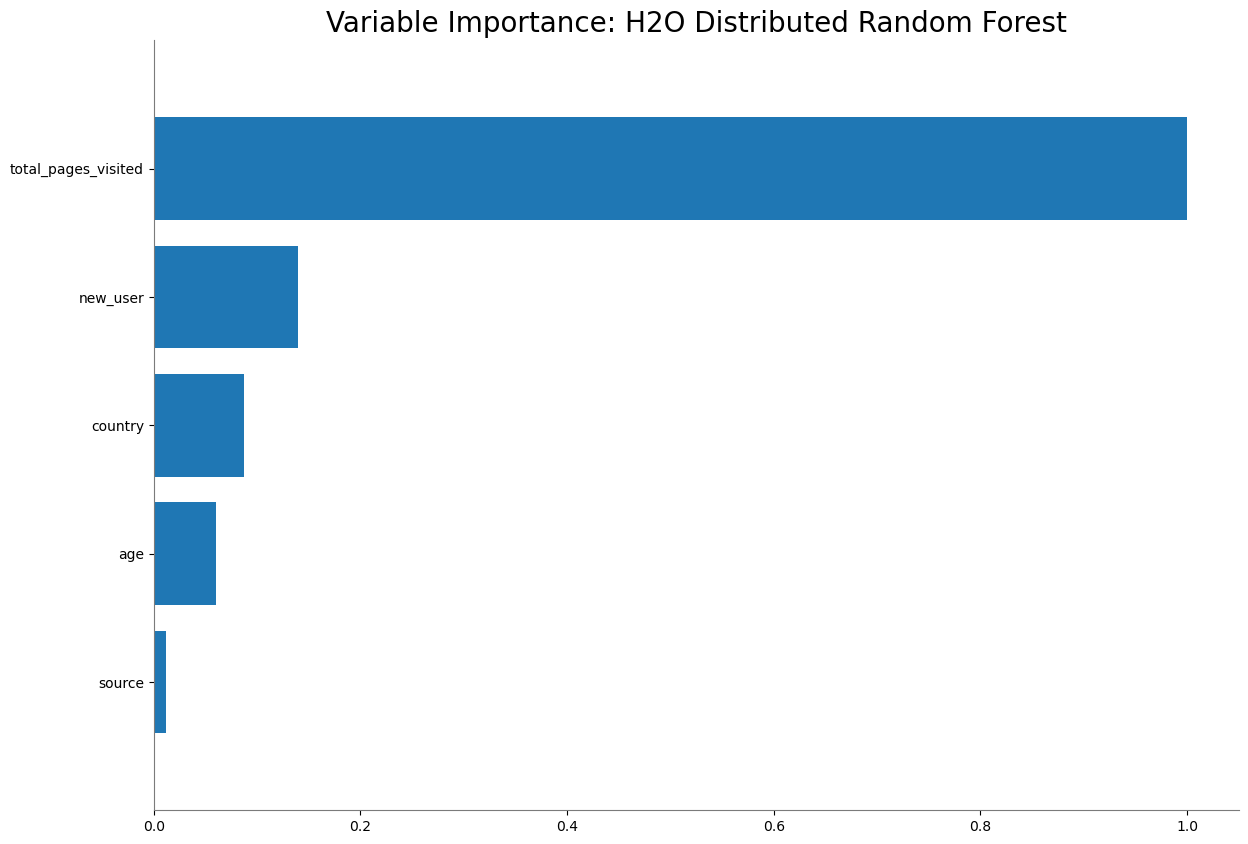

<Figure size 640x480 with 0 Axes>

In [17]:
model.varimp_plot()

## 5.4 Feature importance


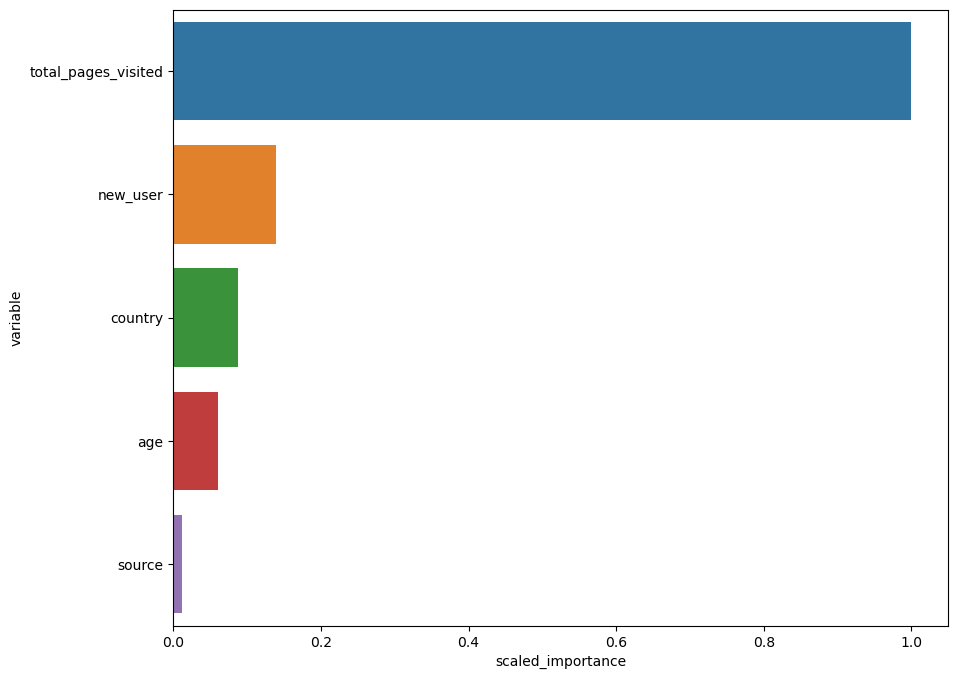

In [18]:
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

## 5.5 Make predictions

In [19]:

train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [20]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.82      0.86     79050
weighted avg       0.98      0.98      0.98     79050


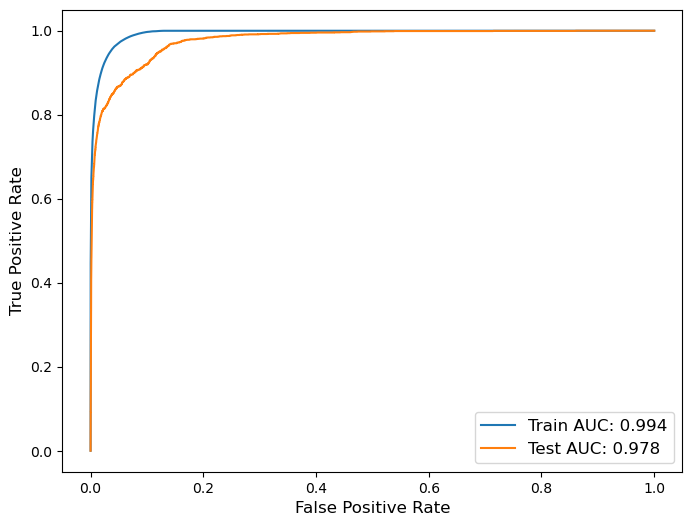

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


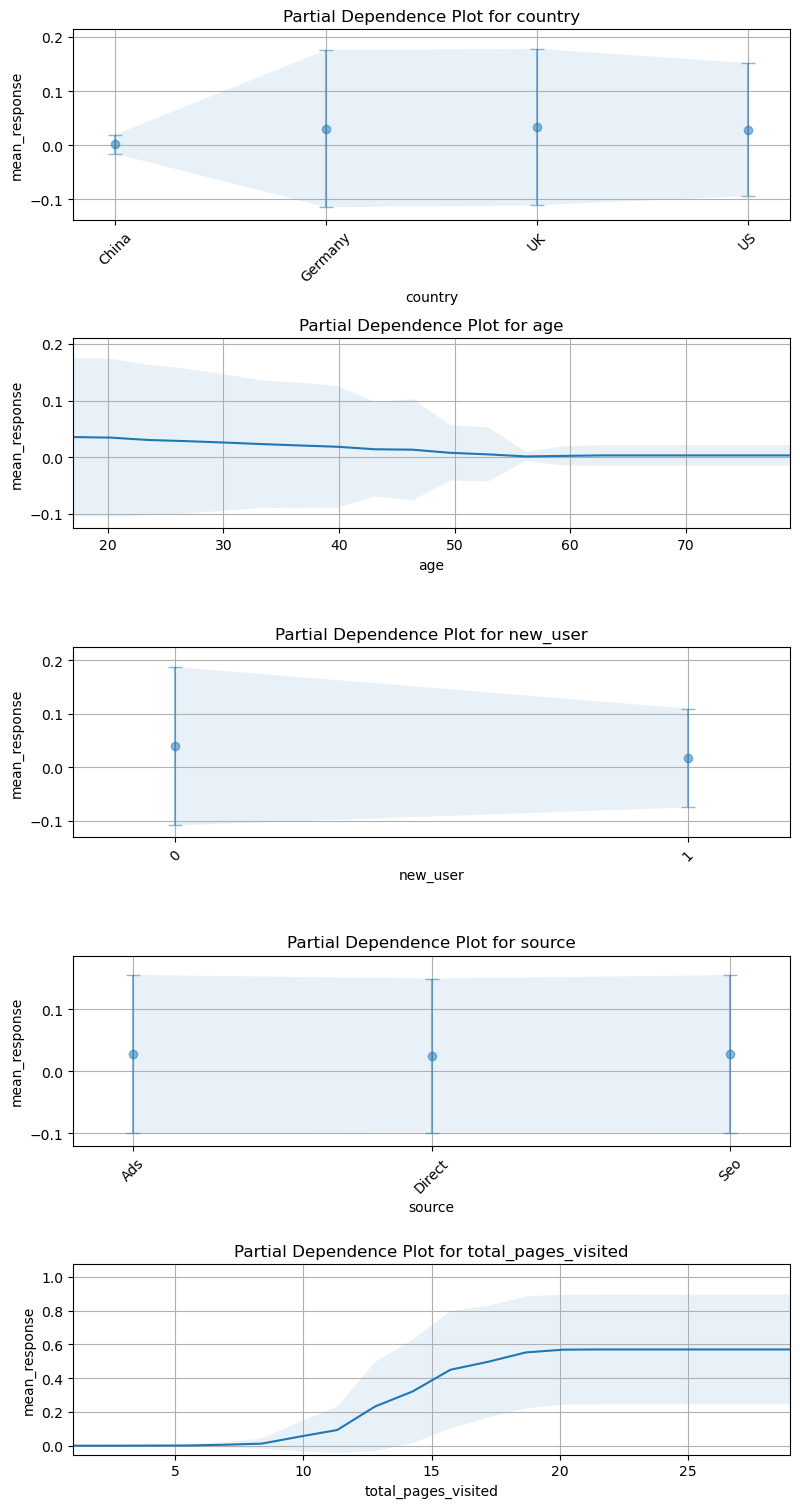

In [22]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

## 5.6 Shutdown h2o instance

In [23]:
h2o.cluster().shutdown()

H2O session _sid_8e84 closed.
